In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline
from scipy.constants import Boltzmann as kb

In [2]:
def parallel(x, y):
    # calculates the parallel impedance of x and y
    z = 1/(1/x + 1/y)
    return z

def get_params(c, lsq, fc=10e6):
    # calculates the snubber resistance that results in the specified cutoff frequecy for the given snubber capacitance and squid input inductance
    
    wc = 2*np.pi*fc
    
    rsq = -2/(wc*c)**2 + (wc*lsq - 1/wc/c)**2
    
    if rsq<=0:
        return np.nan
    else:
        return np.sqrt(rsq)
    
def get_zsnub(f, r, c):
    # calculates the impedance of the snubber for given resistance and capacitance
    w = 2*np.pi*f
    zsnub = r + 1/1j/w/c
    
    return zsnub
    

def get_tf(f, zsnub, lsq):
    # calculates snubber transfer function for given snubber impedance and squid input inductance
    w = 2*np.pi*f   
    zlsq = 1j*w*lsq   
    tf = (zsnub) / (zsnub + zlsq)
   
    return np.absolute(tf)

def get_fc(f, tf):
    # finds cutoff frequency from transfer function
    tf = np.absolute(tf)   
    idx = np.argmin(np.absolute(tf-1/np.sqrt(2)))   
    fc = f[idx]
   
    return fc

def get_max_tf(tf):
    # finds maximum value of snubber transfer function
    # useful for quantifying resonances from snubber
    tf = np.absolute(tf)
    return np.amax(tf)

def get_csf(f, zsnub, lsq, rtes):
    # calculates the current sharing factor for a given snubber impedance, squid input inductance, and TES operating resistance
    w = 2*np.pi*f
    zlsq = 1j*w*lsq
    csf = 1 + zlsq / parallel(zsnub, rtes)
   
    return np.absolute(csf)

def get_nei(f, zsnub, lsq, temp):
    # calculates the snubber johnson noise for given snubber impedance, squid input inductance, snubber temperature
    w = 2*np.pi*f
   
    zlsq = 1j*w*lsq
    zloop = zsnub + zlsq
   
    vn = np.sqrt(4*kb*temp*np.real(zsnub))
   
    nei = np.absolute(vn/(zsnub + zlsq)) * np.sqrt(2)
   
    return nei

# STCR SQUID at 4 K

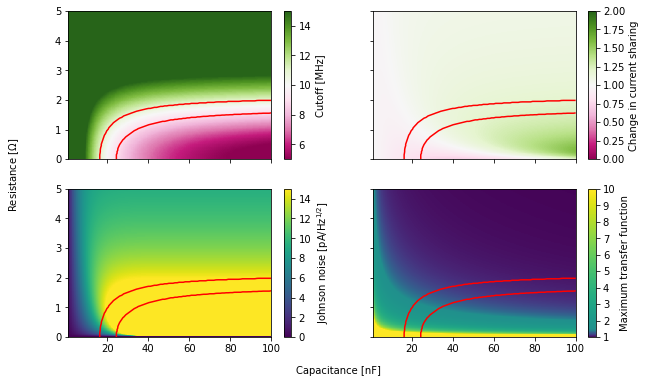

In [3]:
# Idea here is to loop over many resistance and capacitance choices for the snubber and evaluate their effect on
# cutoff frequency, current sharing, johnson noise, and transfer function resonances

##########
# set up #
##########

rtes = 0.8
temp = 4.
lsq = 31e-9 # 11 nH from STCR + 20 nH from stray inductance

n = 100
rs = np.linspace(0, 5, n) # resistance values to use to evaluate snubber
cs = np.linspace(1e-9, 100e-9, n) # capacitance values to use to evaluate snubber

###################
# do calculations #
###################

f_lin = np.linspace(1.5e6, 4.5e6) # frequencies over PB-2 readout band
f_log = np.logspace(5, 8, 1000) # broad frequency range

fc = np.empty((n, n))
max_tf = np.empty((n, n))
max_noise = np.empty((n, n))
max_csf = np.empty((n, n))
max_csf_frac = np.empty((n, n))

for j, r in enumerate(rs): # loop over resistance
    for k, c in enumerate(cs): # loop over capacitance
        
        zsnub_lin = get_zsnub(f_lin, r, c) # snubber impedance over PB-2 readout band
        zsnub_log = get_zsnub(f_log, r, c) # snubber impedance over broad frequency range
        
        tf_log = get_tf(f_log, zsnub_log, lsq) # transfer function over broad frequency range
        
        fc[j][k] = get_fc(f_log, tf_log) # cutoff frequency
        
        max_tf[j][k] = np.amax(np.absolute(tf_log)) # maximum value of transfer fuction (trying to quantify resonances)

        csf = get_csf(f_lin, zsnub_lin, lsq, rtes) # current sharing factor with snubber over PB-2 readout band
        csf0 = get_csf(f_lin, 1e10, lsq, rtes) # current sharing factor without snubber over PB-2 readout band. Here I'm setting the snubber impedance to 1e10, which is so large that the snubber is completely irrelevant to current sharing. 
        max_csf[j][k] = np.amax(csf) # calculate the maximum value of the current sharing factor. Since the current sharing factor depends on frequency, this makes it a little simpler to digest the results
        max_csf_frac[j][k] = np.amax(csf)/np.amax(csf0) # gives the maximum impact of the snubber on the current sharing factor
        
        nei = get_nei(f_lin, zsnub_lin, lsq, temp) # calculates snubber johnson noise over pb-2 frequency band
        max_noise[j][k] = np.amax(nei) # calculates maximum johnson noise, since it depends on frequency

##############
# make plots #
##############

fcmin = 9
fcopt = 10
fcmax = 11

fig, axs = plt.subplots(2, 2, figsize=tuple(np.array([20, 12])*.5), sharex=True, sharey=True, constrained_layout=False)
extent = [np.amin(cs)*1e9, np.amax(cs)*1e9, np.amin(rs), np.amax(rs)]
try:
    fig.supxlabel('Capacitance [nF]')
    fig.supylabel('Resistance [$\Omega$]')
except: 
    fig.text(0.5, 0.04, 'Capacitance [nF]', ha='center')
    fig.text(0.04, 0.5, 'Resistance [$\Omega$]', va='center', rotation='vertical')

# cutoff
ax = axs[0][0]
norm = colors.TwoSlopeNorm(vmin=5, vcenter=10, vmax=15)
im = ax.imshow(fc/1e6, cmap=cm.PiYG, extent=extent, norm=norm, aspect='auto', origin='lower')
fig.colorbar(im, ax=ax, label='Cutoff [MHz]')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red')

# transfer function
ax = axs[1][1]
norm = colors.TwoSlopeNorm(vmin=1, vcenter=1.5, vmax=10.)
im = ax.imshow(max_tf, cmap=cm.viridis, extent=extent, norm=norm, aspect='auto', origin='lower')
fig.colorbar(im, ax=ax, label='Maximum transfer function')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red')

# current sharing
ax = axs[0][1]
norm = colors.TwoSlopeNorm(vmin=0, vcenter=1., vmax=2.)
im = ax.imshow(max_csf_frac, extent=extent, aspect='auto', origin='lower', cmap=cm.PiYG, norm=norm)
fig.colorbar(im, ax=ax, label='Change in current sharing')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red')

# snubber noise
ax = axs[1][0]
norm = colors.TwoSlopeNorm(vmin=0, vcenter=7.5, vmax=15.)
im = ax.imshow(max_noise*1e12, extent=extent, aspect='auto', origin='lower', norm=norm, cmap=cm.viridis)
fig.colorbar(im, ax=ax, label='Johnson noise [pA/Hz$^{1/2}$]')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red') 

plt.show()

R:  0.24620831426687864


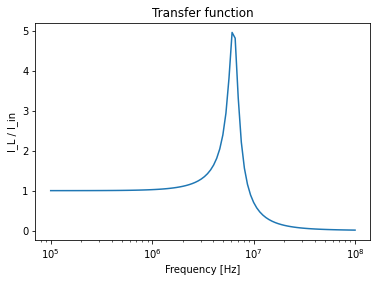

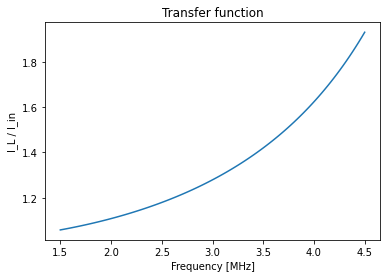

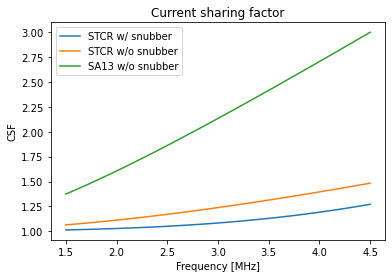

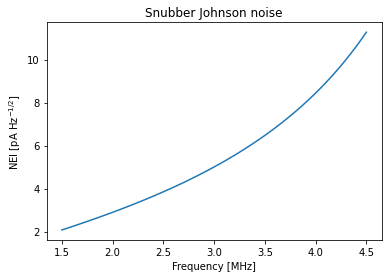

In [4]:
# Here I'm looking at a particular choice of snubber configuration instead of looping over many R and C values

##########
# set up #
##########

c = 20e-9 # my choice

rtes = 0.8
temp = 4.
lsq = 31e-9

r = get_params(c=c, fc=10e6, lsq=lsq) # calculates the resistance that provides a cutoff of fc given my choice of C and the SQUID input inductance
print("R: ", r)
###################
# do calculations # 
###################

f_log = np.logspace(5, 8, 100)
f_lin = np.linspace(1.5e6, 4.5e6, 100)

zsnub_lin = get_zsnub(f_lin, r, c)
zsnub_log = get_zsnub(f_log, r, c)

tf_lin = get_tf(f_lin, zsnub_lin, lsq=lsq)
tf_log = get_tf(f_log, zsnub_log, lsq=lsq)

csf = get_csf(f_lin, zsnub_lin, rtes=rtes, lsq=lsq)
csf_stcr_nosnub = get_csf(f_lin, 1e6, rtes=rtes, lsq=lsq)
csf_sa13_nosnub = get_csf(f_lin, 1e6, rtes=rtes, lsq=80e-9) # I increased lsq to the value it should be for an SA13. I think 70 nH is actually a bit more accurate

nei = get_nei(f_lin, zsnub_lin, lsq, temp)

##############
# make plots #
##############

plt.title('Transfer function')
plt.xlabel('Frequency [Hz]')
plt.ylabel('I_L / I_in')
plt.semilogx(f_log, tf_log)
#plt.axhline(0.707)
plt.show()

plt.title('Transfer function')
plt.xlabel('Frequency [MHz]')
plt.ylabel('I_L / I_in')
plt.plot(f_lin/1e6, tf_lin)
plt.show()

plt.title('Current sharing factor')
plt.xlabel('Frequency [MHz]')
plt.ylabel('CSF')
plt.plot(f_lin/1e6, csf, label='STCR w/ snubber')
plt.plot(f_lin/1e6, csf_stcr_nosnub, label='STCR w/o snubber')
plt.plot(f_lin/1e6, csf_sa13_nosnub, label='SA13 w/o snubber')
plt.legend()
plt.show()

plt.title('Snubber Johnson noise')
plt.xlabel('Frequency [MHz]')
plt.ylabel('NEI [pA Hz$^{-1/2}$]')
plt.plot(f_lin/1e6, nei*1e12)
plt.show()

# SA13 at 4 K

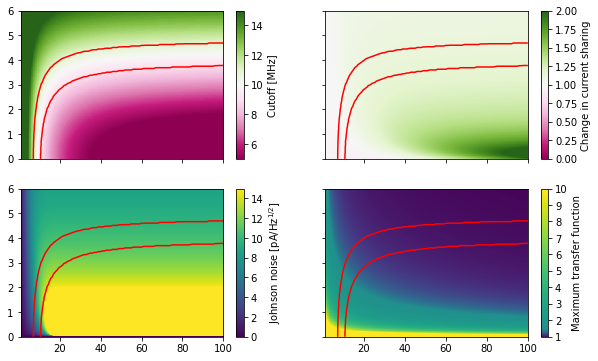

In [58]:
##########
# set up #
##########

rtes = 0.8
temp = 4.
lsq = 70e-9

n = 100
rs = np.linspace(0, 6, n)
cs = np.linspace(1e-9, 100e-9, n)

###################
# do calculations #
###################

f_lin = np.linspace(1.5e6, 4.5e6)
f_log = np.logspace(5, 8, 1000)

fc = np.empty((n, n))
max_tf = np.empty((n, n))
max_noise = np.empty((n, n))
max_csf = np.empty((n, n))
max_csf_frac = np.empty((n, n))

for j, r in enumerate(rs):
    for k, c in enumerate(cs):
        
        zsnub_lin = get_zsnub(f_lin, r, c)
        zsnub_log = get_zsnub(f_log, r, c)
        
        tf_log = get_tf(f_log, zsnub_log, lsq)
        
        fc[j][k] = get_fc(f_log, tf_log)
        
        max_tf[j][k] = np.amax(np.absolute(tf_log))

        csf = get_csf(f_lin, zsnub_lin, lsq, rtes)
        csf0 = get_csf(f_lin, 1e10, lsq, rtes)
        max_csf[j][k] = np.amax(csf)
        max_csf_frac[j][k] = np.amax(csf)/np.amax(csf0)
        
        nei = get_nei(f_lin, zsnub_lin, lsq, temp)
        max_noise[j][k] = np.amax(nei)

##############
# make plots #
##############

fcmin = 9
fcopt = 10
fcmax = 11

fig, axs = plt.subplots(2, 2, figsize=tuple(np.array([20, 12])*.5), sharex=True, sharey=True, constrained_layout=False)
extent = [np.amin(cs)*1e9, np.amax(cs)*1e9, np.amin(rs), np.amax(rs)]
try:
    fig.supxlabel('Capacitance [nF]')
    fig.supylabel('Resistance [$\Omega$]')
except: 
    pass
    #fig.text(0.5, 0.04, 'Capacitance [nF]', ha='center', fontsize=20)
    #fig.text(0.04, 0.5, 'Resistance [$\Omega$]', va='center', rotation='vertical', fontsize=20)

# cutoff
ax = axs[0][0]
norm = colors.TwoSlopeNorm(vmin=5, vcenter=10, vmax=15)
im = ax.imshow(fc/1e6, cmap=cm.PiYG, extent=extent, norm=norm, aspect='auto', origin='lower')
fig.colorbar(im, ax=ax, label='Cutoff [MHz]')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red')

# transfer function
ax = axs[1][1]
norm = colors.TwoSlopeNorm(vmin=1, vcenter=1.5, vmax=10.)
im = ax.imshow(max_tf, cmap=cm.viridis, extent=extent, norm=norm, aspect='auto', origin='lower')
fig.colorbar(im, ax=ax, label='Maximum transfer function')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red')

# current sharing
ax = axs[0][1]
norm = colors.TwoSlopeNorm(vmin=0, vcenter=1., vmax=2.)
im = ax.imshow(max_csf_frac, extent=extent, aspect='auto', origin='lower', cmap=cm.PiYG, norm=norm)
fig.colorbar(im, ax=ax, label='Change in current sharing')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red')

# snubber noise
ax = axs[1][0]
norm = colors.TwoSlopeNorm(vmin=0, vcenter=7.5, vmax=15.)
im = ax.imshow(max_noise*1e12, extent=extent, aspect='auto', origin='lower', norm=norm, cmap=cm.viridis)
fig.colorbar(im, ax=ax, label='Johnson noise [pA/Hz$^{1/2}$]')
ax.contour(cs*1e9, rs, fc/1e6, levels=[fcmin, fcmax], colors='red') 

plt.show()

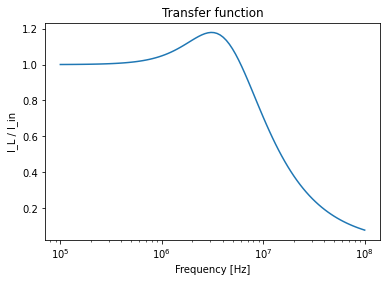

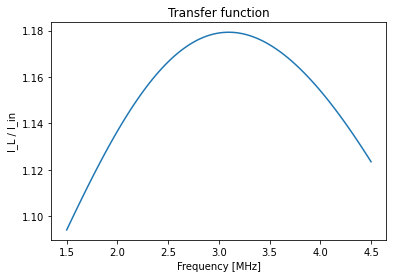

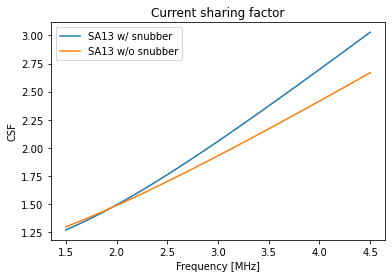

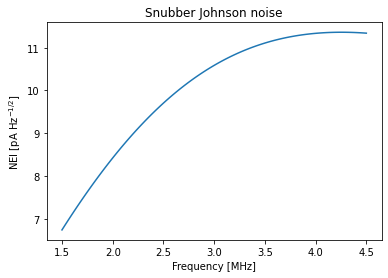

In [69]:
##########
# set up #
##########

rtes = 0.8
temp = 4.
lsq = 70e-9

c = 20e-9
r = get_params(c, lsq, fc=10e6)

###################
# do calculations #
###################

f_log = np.logspace(5, 8, 100)
f_lin = np.linspace(1.5e6, 4.5e6, 100)

zsnub_lin = get_zsnub(f_lin, r, c)
zsnub_log = get_zsnub(f_log, r, c)

tf_lin = get_tf(f_lin, zsnub_lin, lsq=lsq)
tf_log = get_tf(f_log, zsnub_log, lsq=lsq)

csf = get_csf(f_lin, zsnub_lin, rtes=rtes, lsq=lsq)
#csf_stcr_nosnub = get_csf(f_lin, 1e6, rtes=rtes, lsq=lsq)
csf_sa13_nosnub = get_csf(f_lin, 1e6, rtes=rtes, lsq=lsq)

nei = get_nei(f_lin, zsnub_lin, lsq, temp)

##############
# make plots #
##############

plt.title('Transfer function')
plt.xlabel('Frequency [Hz]')
plt.ylabel('I_L / I_in')
plt.semilogx(f_log, tf_log)
plt.show()

plt.title('Transfer function')
plt.xlabel('Frequency [MHz]')
plt.ylabel('I_L / I_in')
plt.plot(f_lin/1e6, tf_lin)
plt.show()

plt.title('Current sharing factor')
plt.xlabel('Frequency [MHz]')
plt.ylabel('CSF')
plt.plot(f_lin/1e6, csf, label='SA13 w/ snubber')
#plt.plot(f_lin/1e6, csf_stcr_nosnub, label='STCR w/o snubber')
plt.plot(f_lin/1e6, csf_sa13_nosnub, label='SA13 w/o snubber')
plt.legend()
plt.show()

plt.title('Snubber Johnson noise')
plt.xlabel('Frequency [MHz]')
plt.ylabel('NEI [pA Hz$^{-1/2}$]')
plt.plot(f_lin/1e6, nei*1e12)
plt.show()